<a href="https://colab.research.google.com/github/M-MSilva/Predict-NBA-player-Points_End-to-end-Project/blob/master/Jupyter_Notebook_Projects/Predict_NBA_player_Points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict NBA player Points - end-to-end project

In addition to creating a project to predict the points of a basketball player, we will answer business questions:

1. Which age group, team and position score the most points per game? 
2. What exactly are the athletes who score the most and give the most assists simultaneously?
3. What is the age group, time and position that makes the most assists? 
4. What exactly are the athletes who have the most turnovers and scores simultaneously?
5. What age group, team and position do the most turnovers? 

Such questions will be answered in section 6 on data visualization.



## 1 - Initial Requirements

Always at the beginning of a project we must import some elementary libraries.

In [1]:
import pandas as pd
import numpy as np

# Python ≥3.5 is required
import sys

# Common imports
import numpy as np
import os

#images
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_theme()

## 2 - Download Data

In this step, we get the data.

In [2]:
Dataset = pd.read_csv('https://raw.githubusercontent.com/M-MSilva/Predict-NBA-player-Points-End-to-end-Project/master/Dataset/NBA_Athletes.csv'
                          ,decimal='.', thousands=',',encoding='utf-8',index_col=0)

rearrange some information

In [3]:
#same categories
Dataset['POS'].replace({'C-F':'F-C','G-F':'F-G'},inplace=True)

#new dataset that will be used for prediction, where we removed the assist attribute per game, to avoid data leakage
NbaDataset = Dataset.drop("APG", axis=1)

## 3 - Initial Data Insights

After all the initial setup we are ready to go to work and extract some precious information from our data. First, we use the head() method on the dataframe to better understand the dataset. As already discussed, this dataset was extracted using **web scraping** from the site 'https://www.nbastuffer.com/player-stats/', where we extracted data from 2021 to 2017.

In [4]:
Dataset.head()

,FULL NAME,TEAM,POS,AGE,GP,MPG,MIN%,USG%,TO%,FTA,FT%,2PA,3PA,PPG,RPG,TRB%,APG,SPG,BPG,TOPG
0,Precious Achiuwa,Tor,F,22.51,63,23.6,49.3,18.2,11.5,109,0.587,398,114,8.8,6.9,15.7,1.1,0.51,0.54,1.16
1,Steven Adams,Mem,C,28.67,68,26.5,55.1,12.3,19.7,184,0.543,349,1,7.1,9.9,19.4,3.2,0.82,0.75,1.56
2,Bam Adebayo,Mia,F-C,24.68,47,32.9,68.5,25.2,14.6,276,0.757,622,5,19.0,10.3,17.6,3.5,1.49,0.83,2.72
3,Santi Aldama,Mem,F-C,21.20,27,10.2,21.4,17.0,7.8,20,0.600,58,39,3.3,2.4,12.0,0.5,0.07,0.26,0.33
4,LaMarcus Aldridge,Bro,F-C,36.68,45,22.8,47.6,22.7,7.8,102,0.873,410,45,13.5,5.6,13.4,0.9,0.31,1.02,0.93


It is worth mentioning that the features were removed from the Dataframe to avoid too many data leaks such as the EFG% which is the Field Goal Effective Percentage.

### 3.1 - Glossary

In the DataFrame above, many features are self-explanatory, so here's some clarification:



*   GP - The number of matches an athlete has played; 
*   MPG -  Minutes per game of the team used by a player; 
*   MIN% - Percentage of team minutes per game used by a player while he was on the court; 
*   USG% - Percentage of team plays used by a player while he was on the court. 
*   TO% - Number of turnover a player makes per 100 possessions; 
*   FTA - The number of free throws a player attempts; 
*   FT% - The percentage of free-throw attempts a player makes;
*   2PA -The number of 2-point field goals a player attempts; 
*   3PA - The number of 3-point field goals a player attempts;
*   PPG - Points per Game (TARGET VALUE); 
*   RPG - Rebounds per game; 
*   TRB% - Percentage of available rebounds grabbed by player while player is on court; 
*   SPG - Steals Per Game; 
*   BPG - Blocks per Game; 
*   TOPG -  Turnovers per Game; 
*   APG - Assistance per Game.


### 3.2 - Dataset Summary

After understanding some attributes, we can get a description of the data with the info() method.

In [5]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1573 entries, 0 to 1572
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FULL NAME  1573 non-null   object 
 1   TEAM       1573 non-null   object 
 2   POS        1573 non-null   object 
 3   AGE        1573 non-null   float64
 4   GP         1573 non-null   int64  
 5   MPG        1573 non-null   float64
 6   MIN%       1573 non-null   float64
 7   USG%       1573 non-null   float64
 8   TO%        1529 non-null   float64
 9   FTA        1573 non-null   int64  
 10  FT%        1573 non-null   float64
 11  2PA        1573 non-null   int64  
 12  3PA        1573 non-null   int64  
 13  PPG        1573 non-null   float64
 14  RPG        1573 non-null   float64
 15  TRB%       1573 non-null   float64
 16  APG        1573 non-null   float64
 17  SPG        1573 non-null   float64
 18  BPG        1573 non-null   float64
 19  TOPG       1573 non-null   float64
dtypes: float

With this, we understand that our dataset has 3 categorical and 17 numeric attributes, totaling 20 columns with 1573 rows. I would really like to collect more data through web scraping, however, the structure of the site 'https://www.nbastuffer.com/player-stats/', changes a bit as the date goes beyond 2017.

### 3.3 - Understanding the data

Now that we know what our numerical attributes are, we can plot them in the form of a histogram. Let's plot various player information on the x-axis by the frequency density on the y-axis.

In [6]:
#a histogram makes more sense with numerical data.
dataset_num = NbaDataset.select_dtypes(include=[np.number])

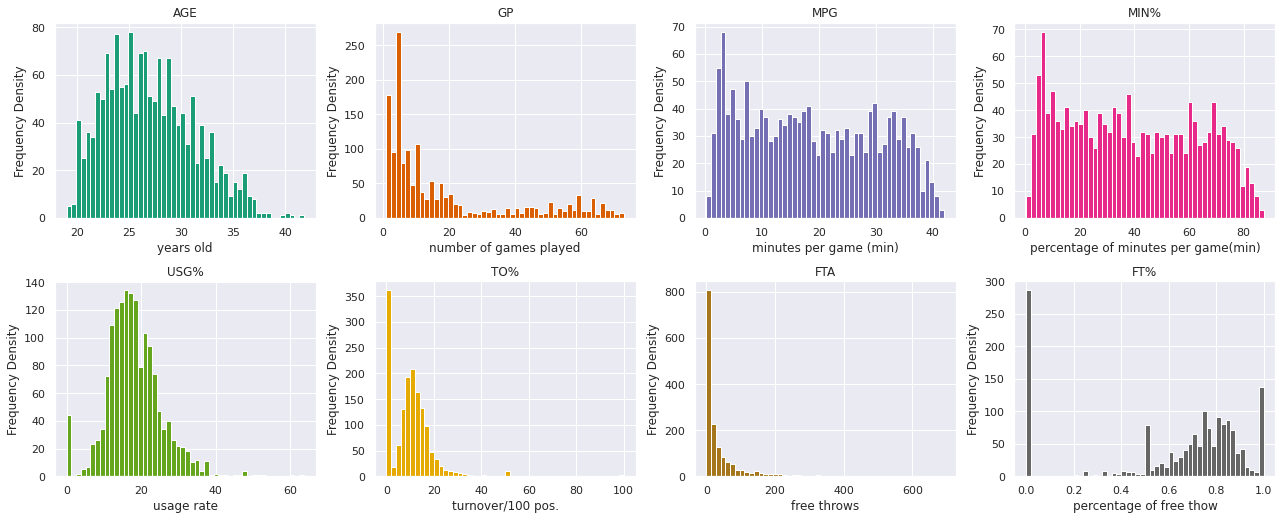

In [7]:
#color map
cmap = mpl.cm.Dark2

fig=plt.figure(figsize=(18,14))

#list with the x label
measurement = ['years old','number of games played','minutes per game (min)','percentage of minutes per game(min)',
               'usage rate','turnover/100 pos.','free throws','percentage of free thow']

#list of data we will plot
data =['AGE','GP','MPG','MIN%','USG%','TO%','FTA','FT%']


#loop that plots all the charts we want, using the hist() method
for i, x, in zip(enumerate(dataset_num),measurement):
  ax=fig.add_subplot(4,4,i[0]+1)
  NbaDataset[i[1]].hist(bins=50,ax=ax,color=cmap(i[0]))
  ax.set_xlabel(x)
  ax.set_ylabel('Frequency Density')
  ax.set_title(i[1])
fig.tight_layout()
plt.show()


In these graphs we understand that the high frequencies of number of games played, minutes per game, usage rate, turnover, free throws happen when values on the x axis revolve around respectively 4.28, 3.33 min, 16%, 2, 13.

In addition to these data, we also plot the remaining data.

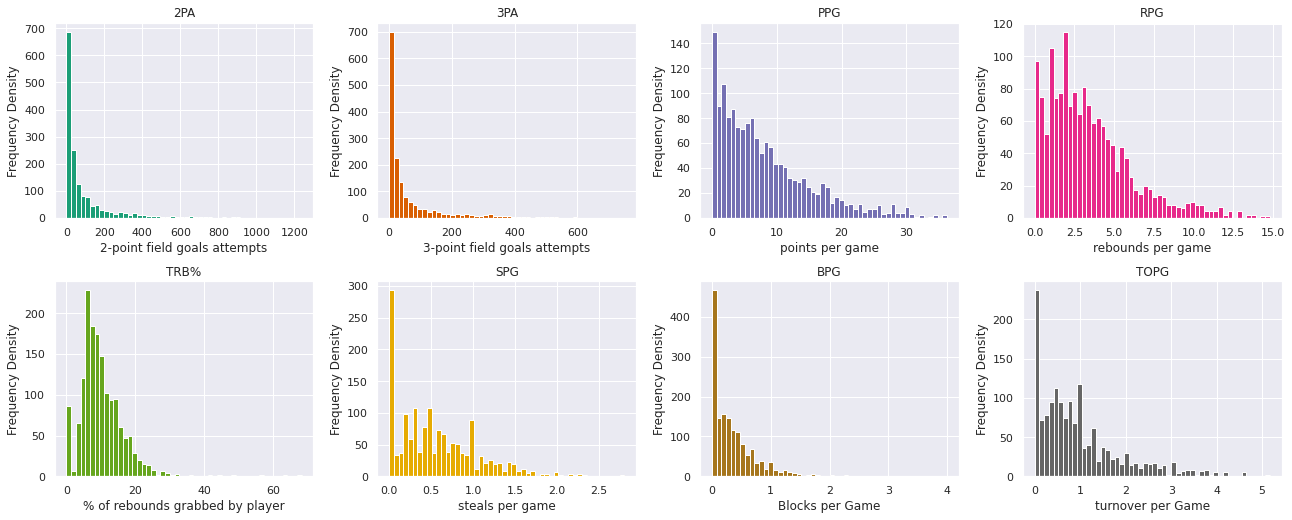

In [8]:
data = ['2PA','3PA','PPG','RPG','TRB%','SPG','BPG','TOPG']

measurement = ['2-point field goals attempts','3-point field goals attempts','points per game','rebounds per game','% of rebounds grabbed by player'
        ,'steals per game','Blocks per Game','turnover per Game']


cmap = mpl.cm.Dark2

fig=plt.figure(figsize=(18,14))

Newdataset_num = dataset_num.iloc[:,8:16]

for i, x, in zip(enumerate(Newdataset_num ),measurement):
  ax=fig.add_subplot(4,4,i[0]+1)
  NbaDataset[i[1]].hist(bins=50,ax=ax,color=cmap(i[0]))
  ax.set_xlabel(x)
  ax.set_ylabel('Frequency Density')
  ax.set_title(i[1])
fig.tight_layout()
plt.show()

Here most values on the x-axis are low when they have high frequencies, even steals per game is around 2.4. It is worth noting that in these two graphs we have a histogram with a long tail, because of this, we will treat our data set with caution later.

To understand the data in an easier way, we will use the describe() method:

In [9]:
NbaDataset.describe()

,AGE,GP,MPG,MIN%,USG%,TO%,FTA,FT%,2PA,3PA,PPG,RPG,TRB%,SPG,BPG,TOPG
count,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1529.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000
mean,26.993484,19.089002,18.794469,39.149841,18.128163,10.087659,39.746980,0.620615,95.001271,62.460267,8.172600,3.413795,10.107883,0.565105,0.358010,0.993846
std,4.223815,20.440654,11.401266,23.756698,7.529271,8.856864,69.469204,0.325143,152.547152,103.187201,7.136968,2.693283,6.387825,0.488581,0.427527,0.950863
min,19.000000,1.000000,0.200000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.670000,5.000000,8.600000,17.900000,13.500000,4.300000,2.000000,0.500000,7.000000,2.000000,2.500000,1.400000,6.200000,0.200000,0.000000,0.330000
50%,26.530000,10.000000,17.900000,37.300000,17.400000,10.000000,13.000000,0.744000,32.000000,20.000000,6.300000,2.800000,8.800000,0.500000,0.250000,0.750000
75%,29.870000,26.000000,29.000000,60.400000,22.100000,14.100000,44.000000,0.842000,110.000000,69.000000,11.800000,4.700000,13.200000,0.860000,0.500000,1.330000
max,41.780000,73.000000,41.900000,87.300000,63.700000,100.000000,691.000000,1.000000,1238.000000,750.000000,36.300000,14.800000,68.200000,2.800000,4.000000,5.170000


Despite the results found in the histogram, the averages give very different results from the majority found previously, which indicates high values for more qualified athletes, this can also be verified due to the high values of standard deviation in 2PA and 3PA. A big regret in our data is that the median of some values approach zero, indicating that in certain cases almost half of the athletes do not perform blocks per game, for example, so, in some data, the count distribution is sparse with many values close to zero, we need to treat such data later.

In addition to the numerical data, in our data we have three categoricals, to find out more information about two of them we will use the value_counts() method,

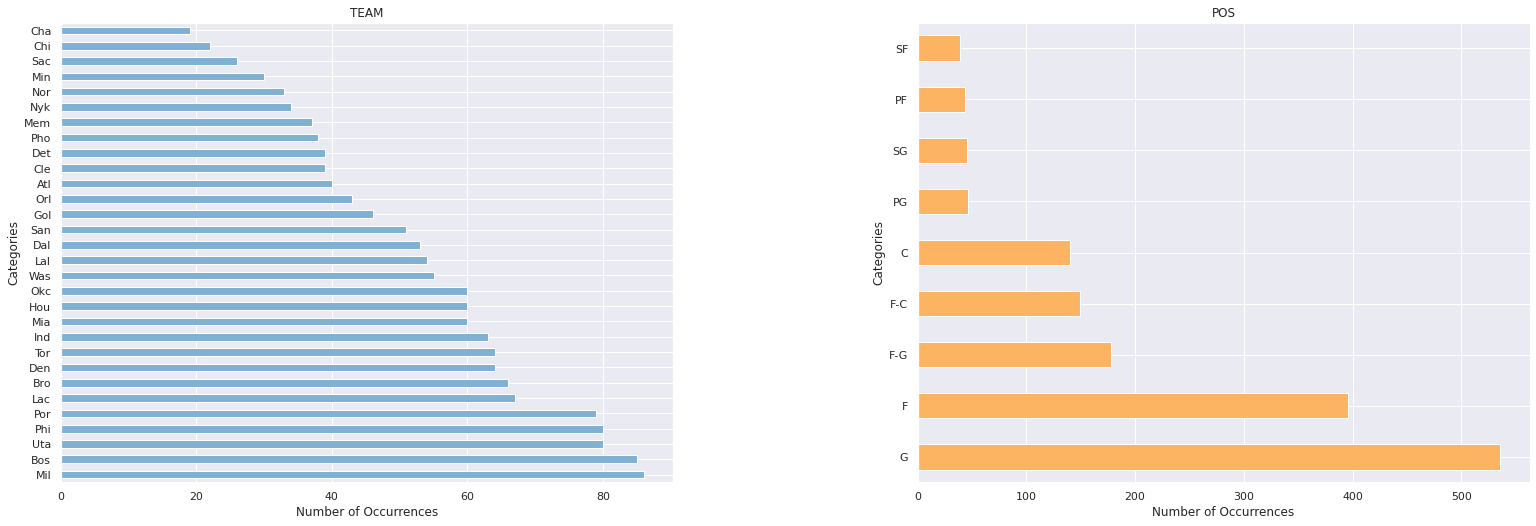

In [10]:
#chosen color map
cmap2 = mpl.cm.Set3

#list of data that we will plot
listFirst = ['TEAM','POS']

fig=plt.figure(figsize=(16,12))

#loop that plots all the data we want using the value_counts() method
for i, col in enumerate(listFirst):
  ax=fig.add_subplot(2,2,i+1)
  plt.xlabel('Number of Occurrences')
  plt.ylabel('Categories')
  valuec = NbaDataset[col].value_counts().plot(kind='barh',title=col,color=cmap2(i + 4),grid=True,ax=ax)
  plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=1.4, 
                    top=1.35, 
                    wspace=0.4, 
                    hspace=0.35)
plt.show()

notamos que a maioria dos atletas se encontram na equipe Mil (Milwaukee Bucks) e a minoria deles pertencem à Cha (Charlotte Hornets). Além do mais, grande parte dos atletas atuam na posição de guarda G, e a minoria deles são SF Small Forward (ALA).

## 4 - Stratified Sampling

As we will see later, the minutes per game of the team used by an athlete is a crucial attribute to estimate the points per game of an athlete, as we do not want biased results we will make a stratified sampling, as we will divide all athletes into smaller and uniform groups, entitled of strata. Finally, we take a fragment of the exact number of instances from each stratum, in order to ensure that the test set characterizes the athletes as a whole.

In our first histogram the minutes per game of the team used by an athlete ranges from 0 min to 40 min approximately, so we will create a category attribute of mini minutes per game, with 5 categories labeled up to 5.

In [11]:
NbaDataset["MPG_cat"] = pd.cut(NbaDataset["MPG"],
                               bins=[0., 10., 20., 30., 40., np.inf],
                               labels=[1, 2, 3, 4, 5])

The minute-per-game categories used by an athlete are shown below:

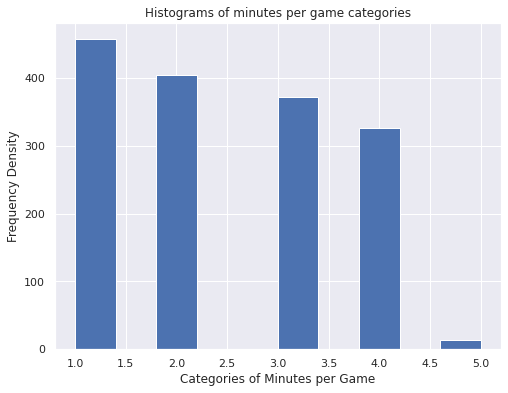

In [12]:
plt.figure(figsize=(8, 6))
NbaDataset["MPG_cat"].hist()
plt.xlabel('Categories of Minutes per Game')
plt.ylabel('Frequency Density')
plt.title('Histograms of minutes per game categories')
plt.show()

after taking subpopulations of athletes, we perform the stratification.

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(NbaDataset, NbaDataset["MPG_cat"]):
    strat_train_set = NbaDataset.iloc[train_index]
    strat_test_set = NbaDataset.iloc[test_index]

To check the consistency of our stratification we make the comparison:

In [14]:
strat_train_set['MPG_cat'].value_counts()/len(strat_train_set)

1    0.290938
2    0.256757
3    0.236884
4    0.207472
5    0.007949
Name: MPG_cat, dtype: float64

In [15]:
NbaDataset['MPG_cat'].value_counts()/len(NbaDataset)

1    0.291163
2    0.256834
3    0.236491
4    0.207247
5    0.008264
Name: MPG_cat, dtype: float64

and we noticed a consistency in the results.

finally we return the data to the original state

In [16]:
import warnings
warnings.filterwarnings("ignore")

for set_ in (strat_train_set, strat_test_set):
    set_.drop("MPG_cat", axis=1, inplace=True)

## 5 - Visualizing data and Answering Some Business Questions

After we've gained insights from our data, it's time to answer the business questions before moving on to the machine learning model. We would like to obtain some information about the age of the athletes, for this we will create age groups with the cut() method.

In [17]:
#our bins
classes = [17,20, 23, 26, 29, 32,35,38,40]

#the labels for each class
labels1 = ['17-20', '20-23', '23-26', '26-29', '29-32','32-35','35-38','38-40']

Dataset['age_cut'] = pd.cut(Dataset["AGE"], bins=classes, labels=labels1)

Now we can start plotting the graphs. An important attribute as we will see later on is the team minutes per game used by a player (MPG). We will initially plot the MPGxPPG and we will highlight the labels to differentiate the age groups of the players,

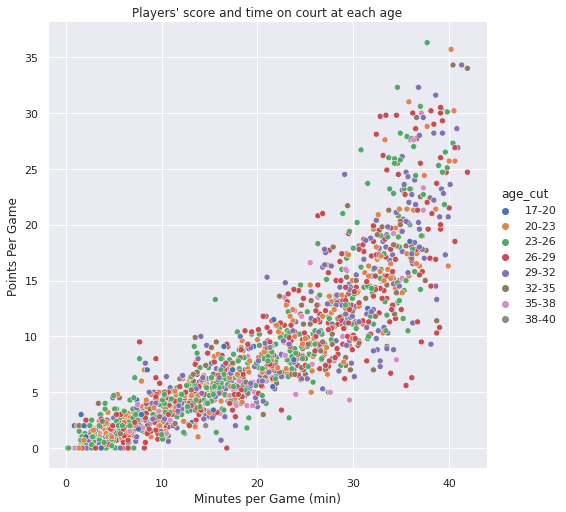

In [18]:
#chart using seaborn
graph = sns.relplot(x=Dataset['MPG'],y=Dataset['PPG'],hue=Dataset['age_cut'],height = 7)
graph.set(title="Players' score and time on court at each age")
graph.set_ylabels("Points Per Game", clear_inner=False)
graph.set_xlabels("Minutes per Game (min)", clear_inner=False)


through this graph we can see the great assimilation of the MPGxPPG attributes, that is, the longer a player is on the court, the more points he scores. In addition, in this graph we understand that the two athletes who punctuate the most were those between 23 and 26 years old and those between 20 and 23 years old. These players punctuate these points in approximately 37-41 min. The player with the fewest points had an age range of 23 to 26 years. Despite these results, which age group pattern scores more?

To answer this question let's use the groupby('variable').sum() method to group data from the same class and add that data to find out which age group, age and team punctuate the most.

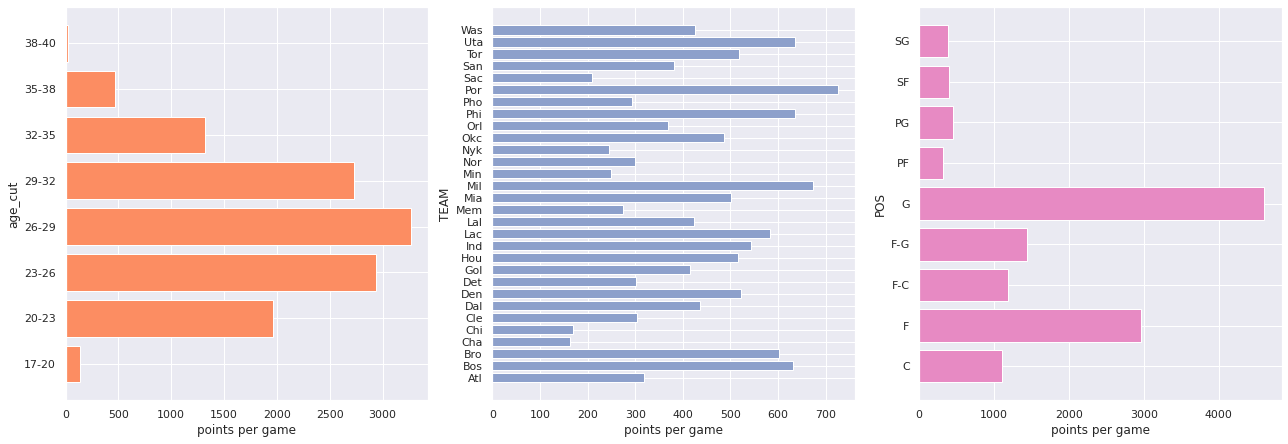

In [19]:
#color map we use 
cmap3 = mpl.cm.Set2

#labels that will be inserted on the y-axis
labels1 = ['17-20', '20-23', '23-26', '26-29', '29-32','32-35','35-38','38-40']
labels2 = [team for team, Dataset in Dataset.groupby('TEAM')]
labels3 = [pos for pos, Dataset in Dataset.groupby('POS')]

#dictionary containing the labels to plot
player_dict = {'l1':labels1,'l2':labels2,'l3':labels3}

#the list that we are going to go through to find the best ponctuate for each category
resultsList = ['age_cut','TEAM','POS']

fig=plt.figure(figsize=(18,18))


for val,i in zip(enumerate(player_dict.values()),resultsList):
  #use the groupby('age_cut').sum() methods to group the tracks for example and sum the data of their group
  results = Dataset.groupby(i).sum()
  ax=fig.add_subplot(3,3,val[0]+1)
  #we plot the vertical bar
  ax.barh(val[1],results['PPG'],color=cmap3(val[0] + 1))
  ax.set_ylabel(i)
  ax.set_xlabel('points per game')
fig.tight_layout()
plt.show()


In this graph we have the classes that score the most points per game, so we understand that the age of the players who score the most points varies from 26-29 years, and those who score the least are those with 38-40 years. Similarly, the team that scores the most is the Portland Trail Blazers (POR), and the one that scores the least is the Charlotte Hornets (Cha). Finally, the positions that score the most are Guard (G), and the ones that score the least are Power forward (PF)

We could make the same scatter chart as before for the position of the players and for the team as well, however, the information obtained in that scatter chart was enough, since this chart does not give us statistical information, however what if we wanted to know who exactly the players are who score the most? For this we will plot the scores and assistance of the players.

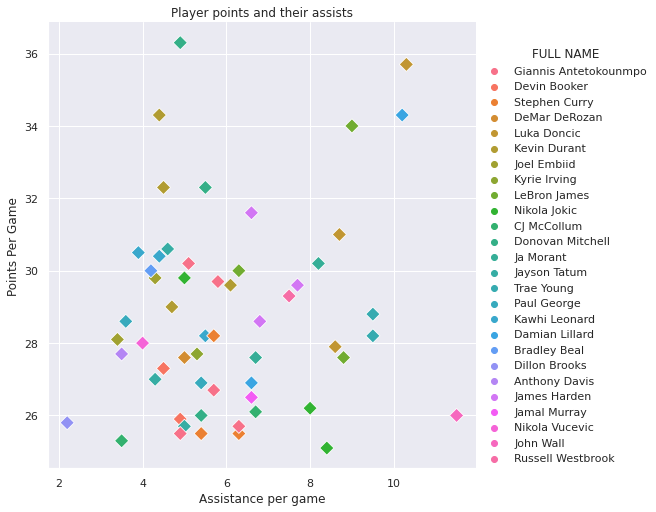

In [20]:
#we caught the baddest players
fewerdata = Dataset[(Dataset['PPG'] > 25) & (Dataset['APG'] > 2)].copy()

#we plot
graph = sns.relplot(x=fewerdata['APG'],y=fewerdata['PPG'],height = 7,hue=fewerdata['FULL NAME'],s=100,marker=r'D')
graph.set(title="Player points and their assists")
graph.set_ylabels("Points Per Game", clear_inner=False)
graph.set_xlabels("Assistance per game", clear_inner=False)

The athlete with the highest score is Donovan Mitchell, and the athlete with the most assists and the second highest number of points is Luka Doncic. There are other athletes who have more assistance, but they didn't score more than 25 points per game, so they don't appear on the chart as is the case with Rajon Rondo. Furthermore, some players appear more than once because in our data we have several seasons in which the same player may have participated.

As we've already plotted the assists before, we can see similarly to the previous graphs, which are the age groups, teams and positions of the players who perform the most assists.

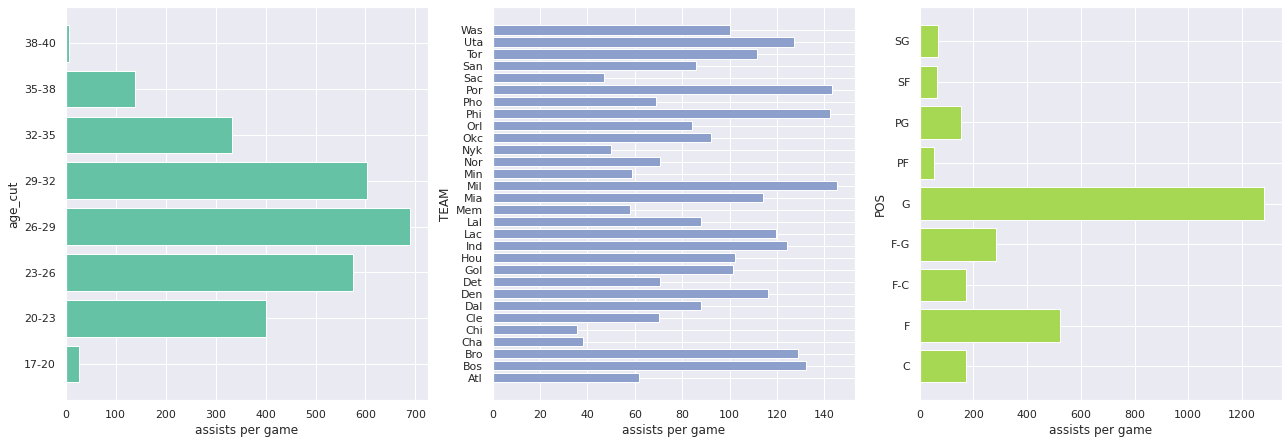

In [21]:
#The following chart has the same structure as the previous ones
player_dict = {'l1':labels1,'l2':labels2,'l3':labels3}

resultsList = ['age_cut','TEAM','POS']

fig=plt.figure(figsize=(18,18))


for val,i in zip(enumerate(player_dict.values()),resultsList):
  results = Dataset.groupby(i).sum()
  ax=fig.add_subplot(3,3,val[0]+1)

  ax.barh(val[1],results['APG'],color=cmap3(val[0]/(val[0] + 2)))

  ax.set_ylabel(i)
  ax.set_xlabel('assists per game')
fig.tight_layout()
plt.show()


Once again, the players who assist the most are 26-29 years old, and the least assists are 38-40 years old. Similar to the previous chart, the team that has the most assists is the Milwaukee Bucks (MIL), the one that does the least is the Chicago Bulls (Chi). Finally, the psition that most assists is guard (G), and the one that least assists is power forward (PF).

Despite the similarity between the graphs of the previous cells, we can easily verify that the results are different from both graphs.

In [22]:
results = Dataset.groupby('age_cut').sum()
print(max(results['PPG']),max(results['APG']))

3266.5 689.6


One relevant thing that we will see later on is the relevance of the TOPG attribute, which is the number of turnovers per game. In basketball, a turnover occurs when a team loses possession of the ball to the opposing team before a player tries to hit his team's basket, increasing the chance of the team that performed the turnover, scoring a point, hence its importance.

To find out who are the players who most turnover and points per game, we will plot again the graph that appears to be a scatter.

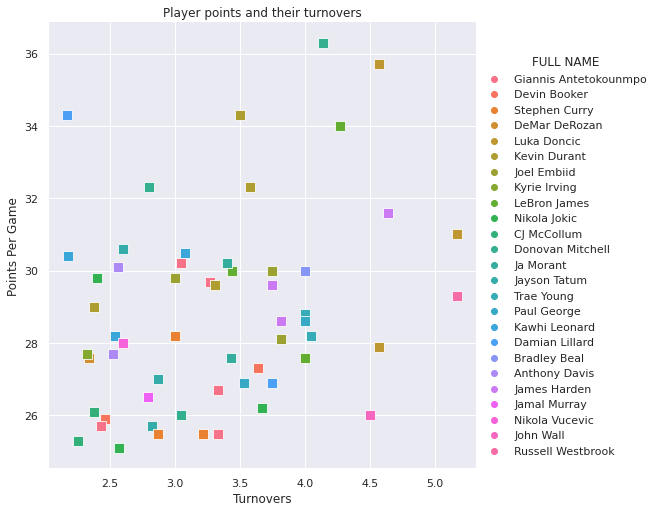

In [23]:
#caught the best players
morefewerdata = Dataset[(Dataset['PPG'] > 25) & (Dataset['TOPG'] > 2)].copy()

#plot
graph = sns.relplot(x=morefewerdata['TOPG'],y=morefewerdata['PPG'],height = 7,hue=morefewerdata['FULL NAME'],s=100,marker=r's')
graph.set(title="Player points and their turnovers")
graph.set_ylabels("Points Per Game", clear_inner=False)
graph.set_xlabels("Turnovers", clear_inner=False)

The players who scored the most points we already know, but the one who simultaneously made more turnover and more points on this graph was Luka Doncic.

Finally, we would like to know which age groups, teams and positions of players perform the most turnovers.

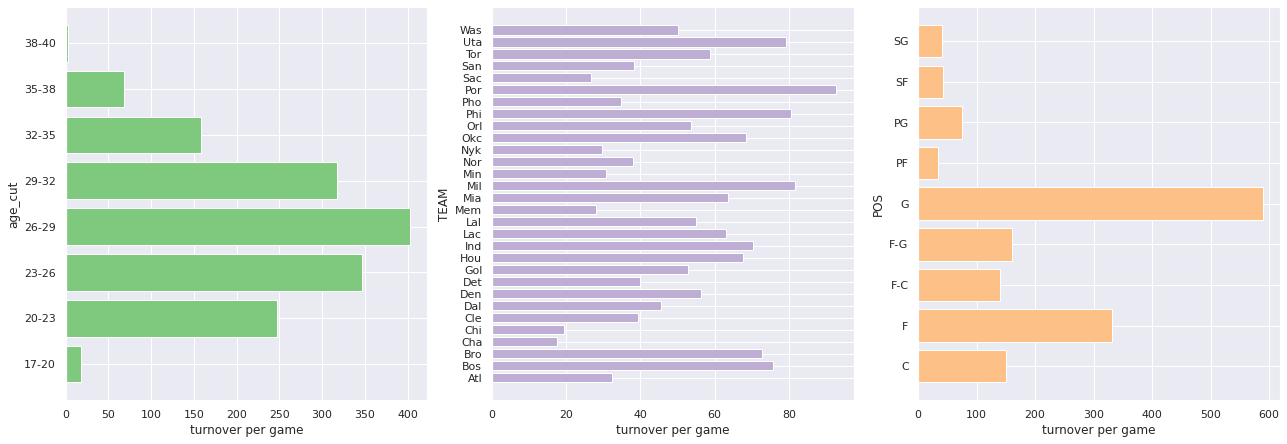

In [24]:
cmap4 = mpl.cm.Accent

fig=plt.figure(figsize=(18,18))


for val,i in zip(enumerate(player_dict.values()),resultsList):
  results = Dataset.groupby(i).sum()
  ax=fig.add_subplot(3,3,val[0]+1)

  ax.barh(val[1],results['TOPG'],color=cmap4(val[0]/(val[0] + 4)))

  ax.set_ylabel(i)
  ax.set_xlabel('turnover per game')
fig.tight_layout()
plt.show()


In the first graph we have the same result obtained previously, in the second graph we find that the team that performed the most turnover was the Portland Trail Blazers (Por), and the team that performed the most turnover was the Charlotte Hornets (Cha). In the last graph, the position with the highest turnover was Guard (G), and the one with the least turnover was the power forward (PF).

We could spend more time here checking other attributes, however, as the model's proposal is to predict the points per game of an athlete, we focus more on the variables most related to this target value, which we will see later because with the correlation matrix .

## 6 - Exploratory Data Analysis and Feature Engineering

As you may have seen we were working in some cases with the 'Dataset' dataset I did this, because I think the 'Dataset' attribute Per Game Assistance (APG) is not a legitimate attribute, so just in case I created two sets of data. From now on we will use the 'NbaDataset' dataset which does not have such an attribute.

### 6.1 - Creating New Data


Now we will test combinations of features to create new data. Initially, we will take a copy of our training data.

In [25]:
NbaDataset = strat_train_set.copy()

To create the new attributes we will do the following, we have several data that were created for each game, basically we will multiply these values by the number of games that players played. Furthermore, the data that was not created for each game will also be created, that is, we will divide this data by the games played attribute.

In [26]:
NbaDataset['MT'] = NbaDataset['MPG']*NbaDataset['GP'] #create the total minutes of a player on court
NbaDataset['FTAPG'] = NbaDataset['FTA']/NbaDataset['GP'] # free throw attempts per game
NbaDataset['2PAPG'] = NbaDataset['2PA']/NbaDataset['GP'] #attempts to fild goals of two points per match
NbaDataset['3PAPG'] = NbaDataset['3PA']/NbaDataset['GP'] #attempts to fild goals of 3 points per match
NbaDataset['RT'] = NbaDataset['RPG']*NbaDataset['GP'] #total rebounds
NbaDataset['RT'] = NbaDataset['SPG']*NbaDataset['GP'] #total robberies
NbaDataset['BT'] = NbaDataset['BPG']*NbaDataset['GP'] #total blocks
NbaDataset['TOT'] = NbaDataset['TOPG']*NbaDataset['GP'] # Turn Over Total

### 6.2 Search for Correlations


Now one of the most important parts of the project has arrived, because we are going to try to understand how the attributes of our dataset relate to each other, for this we will use the correlation coefficient through the corr() method.

In [27]:
Matrix_corr = NbaDataset.corr()
Matrix_corr['PPG'].sort_values(ascending=False)

PPG      1.000000
2PAPG    0.921830
MIN%     0.878182
MPG      0.878172
FTAPG    0.862689
TOPG     0.831177
3PAPG    0.755774
RPG      0.691177
SPG      0.641844
FTA      0.578424
2PA      0.573604
USG%     0.542443
TOT      0.538108
FT%      0.472791
MT       0.470625
3PA      0.463182
RT       0.422013
BPG      0.399867
BT       0.305581
GP       0.268209
AGE      0.106283
TRB%     0.002345
TO%     -0.047969
Name: PPG, dtype: float64

The correlation coefficient close to 1 reveals a positive relationship between the data, if the correlation coefficient is close to -1 it expresses a negative relationship. For example, a player's points tend to increase the more he tries to hit 2-point fild goals, the points per game a player scores tend to increase as TO% decreases (number of turnover a player commits per 100 possessions) note that It's not the TOPG. Now we know why we stratified our data into five categories of minutes per game used by a player on court (MPG), as the relationship with the target value is high, around 0.87.

Furthermore, we can look at these relationships in the form of a heat map.

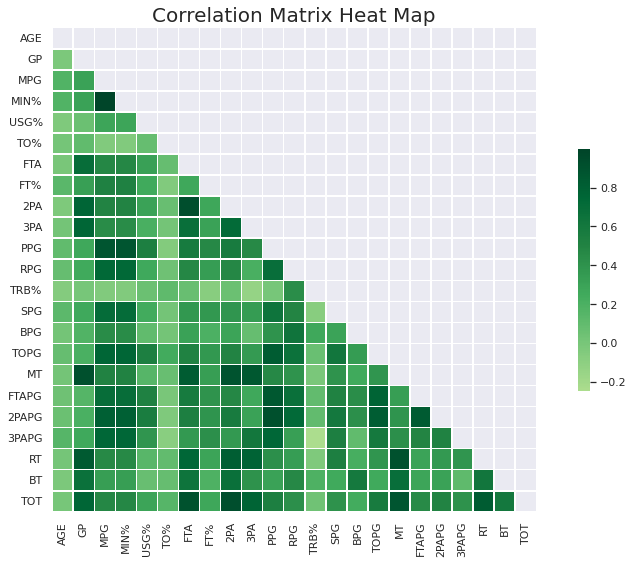

In [28]:
#we avoid a repetition of the correlation map with mask
mask = np.triu(np.ones_like(Matrix_corr))

f=plt.figure(figsize=(12,8))

#we create the heat map
graph = sns.heatmap(Matrix_corr,mask=mask,cmap=plt.get_cmap("YlGn"),center=0,square=True,linewidths=.5,cbar_kws={"shrink": .5})
graph.set_title("Correlation Matrix Heat Map",fontsize = 20)
sns.set(font_scale = 1)
f.tight_layout()

Most impressive in our attribute correlation heatmap is the relationship between PA2PG (2 points per game) and PPG (points per game), as we also see again the strong relationship between PPG and MPG.

### 6.3 Prepare the Data

First we will return to our dataset without any changes, and we will split the labels and predictors as we cannot impute transformations on the labels.

In [29]:
NbaDataset = strat_train_set.drop(columns=['PPG','FULL NAME'], axis=1) # drop labels for training set
Nba_labels = strat_train_set['PPG'].copy()

NbaDataset = NbaDataset.astype({'GP':'float','FTA':'float','2PA':'float','3PA':'float'})

Nba_num = NbaDataset.select_dtypes(include=[np.number])#only the numerical data for later

### 6.4 - Creating our own transformer

We already know what our attributes will be created through combinations, however we must create a standard transformer to incorporate our combined attributes into the dataset when we are going to use the pipeline transformation. A pepiline transformation sequentially employs several estimates and transformations through fit_transform() on the data. In other words, we must do this, because our pipeline needs to have a fit() and transform(), which was not done in our usual creation of previous data.

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin # the TransformerMixin to ensure fit_transform()

#we must first get the column indices
names = "GP", "FTA", "2PA", "3PA","TOPG"
gp_ix, fta_ix, pa2_ix, pa3_ix, topg_ix = [Nba_num.columns.get_loc(i) for i in names ] 

#create the transformer that will imput the fit_transform
class CreateCombinedAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, add_PA2PG=True,add_FTAPG=True,add_PA3PG=True): 
        self.add_PA2PG = add_PA2PG
        self.add_FTAPG = add_FTAPG
        self.add_PA3PG = add_PA3PG
    def fit(self, X, y=None):
        return self #to implement the fit method
    def transform(self, X): 
        TOT = X[:, topg_ix]*X[:, gp_ix]
        if (self.add_PA2PG & self.add_FTAPG & self.add_PA3PG):
            PA2PG = X[:, pa2_ix] / X[:, gp_ix]
            FTAPG = X[:, fta_ix] / X[:, gp_ix]
            PA3PG = X[:, pa3_ix] / X[:, gp_ix]
            return np.c_[X, FTAPG, PA3PG,
                         PA2PG,TOT]
        else:
            return np.c_[X, TOT]

We don't all create the same resources as before, as some of them are not that important. the initial setting add_PA2PG=True will tell us if the PA2PG parameter is really relevant as well as the others.

### 6.5 - Transformations by Pipelines (Cleaning, scaling, etc...)

In our dataset, some attributes have null values:

In [31]:
pd.isnull(NbaDataset).sum()

TEAM     0
POS      0
AGE      0
GP       0
MPG      0
MIN%     0
USG%     0
TO%     36
FTA      0
FT%      0
2PA      0
3PA      0
RPG      0
TRB%     0
SPG      0
BPG      0
TOPG     0
dtype: int64

As our data has many imperfections we must remedy them by employing a pepilines transformation, which sequentially applies various estimates and transformations to the data through the fit_transform() method. In our pipeline:

1. First, we fill in the missing data in the dataset, with the column's median through the SimpleImputer(strategy='median') method;
2. Then with our CreateCombinedAttributes() method we create the combined attributes;
3. We apply the PowerTransformer() method which employs Loarithmic and power transformations to improve normality or symmetry in the data. We do this because in our first two plots (of section 4.3) we have those long tails in the histograms, and this method generates more Gauss-like data.
4. Finally, we use the MinMaxScaler(), which makes the data have similar weights, so that this normalization induces our data to be in a range from 0 to 1.

In [32]:
#Such transformations in our numeric attributes

from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler,PowerTransformer

#pipeline that enforces the transformations
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('crate_attributes', CreateCombinedAttributes()),
        ('PowerTransformer',PowerTransformer(method='yeo-johnson',standardize=True)),
        ('MinMaxScaler',MinMaxScaler()),
          
    ])

dataset_num_tr = num_pipeline.fit_transform(Nba_num)

Now we join our numerical and categorical data through the ColumnTransformer and use the OneHotEncoder method, to transform words into numbers, as the models do not work with words, only numbers.

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#list the numerical data
num_attribs = list(Nba_num)


dataset_cat = NbaDataset.select_dtypes(include=['object'])#take the categorical data
cat_attribs = list(dataset_cat)#list the categorical data

#apply the total transformation to the categorical and numerical data
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(handle_unknown = 'ignore'), cat_attribs)
    ])



dataset_prepared = full_pipeline.fit_transform(NbaDataset)

## 7 - Choose and Train The Model

In this step, we will analyze several models in order to find the best one for our project, as our dataset is not very large, we will

In [34]:
#Regression based on k-nearest neighbors
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor().fit(dataset_prepared, Nba_labels)
scoreknn = knn.score(dataset_prepared, Nba_labels)


#Linear Regression
from sklearn.linear_model import LinearRegression
linreg = LinearRegression().fit(dataset_prepared, Nba_labels)
scoreline = linreg.score(dataset_prepared, Nba_labels)


#Ridge Regression
from sklearn.linear_model import Ridge
RidgeReg = Ridge(alpha=1,solver='sag',random_state=42).fit(dataset_prepared, Nba_labels)
scoreRidge = RidgeReg.score(dataset_prepared, Nba_labels)


#Lasso Regression
from sklearn.linear_model import Lasso
LassoReg = Lasso(alpha=0.001,random_state=42,max_iter = 10000).fit(dataset_prepared, Nba_labels)
scoreLasso = LassoReg.score(dataset_prepared, Nba_labels)


#Epsilon-Support Vector Regression
from sklearn.svm import SVR
SVRreg = SVR(kernel = 'rbf').fit(dataset_prepared, Nba_labels)
scoreSVR = SVRreg.score(dataset_prepared, Nba_labels)


#Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
DecisionReg = DecisionTreeRegressor(min_samples_split=20,random_state=42).fit(dataset_prepared, Nba_labels)
scoreDtree = DecisionReg.score(dataset_prepared, Nba_labels)


#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
RFreg  = RandomForestRegressor(random_state=42).fit(dataset_prepared, Nba_labels)
scoreRFreg = RFreg.score(dataset_prepared, Nba_labels)


#Extreme Gradient Boosting for regression
from xgboost import XGBRegressor
XGBreg = XGBRegressor(objective ='reg:squarederror',random_state=42).fit(dataset_prepared, Nba_labels)
scoreXGBreg = XGBreg.score(dataset_prepared, Nba_labels)


### 7.1 - Finding the best model

we will plot the scores of each model:

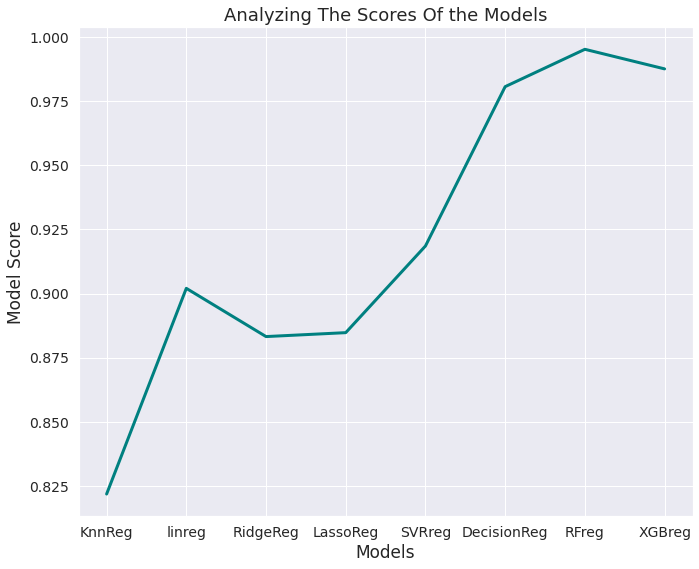

In [35]:
names = ['KnnReg','linreg','RidgeReg','LassoReg','SVRreg','DecisionReg','RFreg','XGBreg']
values = [scoreknn,scoreline,scoreRidge,scoreLasso,scoreSVR,scoreDtree,scoreRFreg,scoreXGBreg]

fig, ax = plt.subplots(figsize=(11, 9))
  
# plot the data
ax.plot(names, values,lw=3,color = 'teal')
ax.set_title('Analyzing The Scores Of the Models',fontsize=18)
ax.set_xlabel('Models',fontsize=17)
ax.set_ylabel('Model Score',fontsize=17)
  
# change the fontsize
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.tick_params(axis='both', which='major', labelsize=14)

# show the plot
plt.show()

It seems that the best models are decision treen, Random Forest Regressor and Extreme Gradient Boosting for regression, so we will expose them here,

In [36]:
print('Random Forest Regressor Score:', scoreRFreg, ', Extreme Gradient Boost Score for Regression:',scoreXGBreg)

Random Forest Regressor Score: 0.99517319110807 , Extreme Gradient Boost Score for Regression: 0.9875431617037801


but the winner can occur the Extreme Gradient Boost regression, as the Rand Forest Regressor can occur an adjustment.

Extreme Gradient Boosting is a model that has perfected Gradient Boosting, so to understand XGBRegressor we must first know how Gradient boosting works. Basically Gradient Boosting sequentially embeds predictors into a set (these sets are built using decision tree models), all of which correct their previous predictor. This operation causes the new predictors to be adapted based on the residual error performed by the preceding predictor. Extreme Gradient Boost enjoys "a more regularized model formalization to control over-fitting, which gives it better performance" (Tianqi Chen)



For one more evaluation of the model, we used the Mean Square Error, which measures the mean squared difference between the recorded values and the real value.

In [37]:
from sklearn.metrics import mean_squared_error


dataset_predictions = XGBreg.predict(dataset_prepared)
lin_mse = mean_squared_error(Nba_labels, dataset_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.8032056502908369

our model is good, because the closer to zero the better.

### 7.2 - Using cross validation

Now we will divide the training set into 10 different subgroups called folds, after this procedure the method evaluates the Extreme Gradient Boost model 10 times, each time selecting a different fold for training and evaluation among the 9 folds.

In [38]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(XGBreg, dataset_prepared, Nba_labels, cv=10)


In [39]:
def display_scores(scores):
    print("\n Scores:", scores)
    print("\n Standard deviation:", scores.std())
    print("\n Mean:", scores.mean())

display_scores(scores)


 Scores: [0.97010431 0.94843396 0.96445295 0.97379446 0.97651405 0.96611678
 0.96349309 0.97268869 0.96668437 0.97153209]

 Standard deviation: 0.007497518002143043

 Mean: 0.9673814747864501


Our model looks like everything is ok.

## 8 - Perfecting the Model

Now that we know the model is good, let's see if we can improve it further.

### 8.1 - Randomized Search

We will look for several hyperparameters to be tested in our model using cross-validation. For this we will use the random search.

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from xgboost import XGBRegressor

xgb = XGBRegressor()
parameters = {
              'objective':['reg:linear','reg:squarederror','reg:gamma','reg:tweedie'],
              'learning_rate': [.03, 0.05, .07 , .01], #so called `eta` value
              'max_depth': [5, 6, 7,8,9],
              'min_child_weight': [2,4,6,8],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [3, 10, 30,100]
              ,'max_features': [2,5,8,14,20]}

xgb_grid =  RandomizedSearchCV(xgb, param_distributions=parameters,
                                n_iter=10, cv=5, random_state=42)


xgb_grid.fit(dataset_prepared, Nba_labels)

RandomizedSearchCV(cv=5, estimator=XGBRegressor(),
                   param_distributions={'colsample_bytree': [0.7],
                                        'learning_rate': [0.03, 0.05, 0.07,
                                                          0.01],
                                        'max_depth': [5, 6, 7, 8, 9],
                                        'max_features': [2, 5, 8, 14, 20],
                                        'min_child_weight': [2, 4, 6, 8],
                                        'n_estimators': [3, 10, 30, 100],
                                        'objective': ['reg:linear',
                                                      'reg:squarederror',
                                                      'reg:gamma',
                                                      'reg:tweedie'],
                                        'silent': [1], 'subsample': [0.7]},
                   random_state=42)

with that the best hyperparameters,

In [41]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.07,
 'max_depth': 6,
 'max_features': 14,
 'min_child_weight': 8,
 'n_estimators': 100,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.7}

and the best estimators are.

In [42]:
xgb_grid.best_estimator_

XGBRegressor(colsample_bytree=0.7, learning_rate=0.07, max_depth=6,
             max_features=14, min_child_weight=8, silent=1, subsample=0.7)

In addition we can find the best features.

In [43]:
feature_importances = xgb_grid.best_estimator_.feature_importances_

In [44]:
extra_attribs = ["FTAPG", "PA3PG","TOT","PA2PG"]
attributes = num_attribs + extra_attribs 

sorted(zip(feature_importances, attributes), reverse=True)

[(0.37176296, 'MIN%'),
 (0.28317577, 'TOT'),
 (0.18125382, 'MPG'),
 (0.06998328, 'USG%'),
 (0.01870528, 'FTAPG'),
 (0.016975604, 'PA3PG'),
 (0.003418861, '3PA'),
 (0.0033419393, '2PA'),
 (0.0030465147, 'FTA'),
 (0.0025537063, 'FT%'),
 (0.0023837043, 'TOPG'),
 (0.0021429434, 'BPG'),
 (0.002090025, 'RPG'),
 (0.002024364, 'TO%'),
 (0.0019787478, 'GP'),
 (0.0017267463, 'AGE'),
 (0.001712283, 'SPG'),
 (0.0016680682, 'TRB%'),
 (0.0014511782, 'PA2PG')]

For this result we will discard some features.

In [45]:
NbaDataset = strat_train_set[['MIN%','MPG','TOPG','GP','USG%','FTA','2PA','3PA','BPG']].copy()
Nba_labels = strat_train_set['PPG'].copy()

NbaDataset = NbaDataset.astype({'GP':'float','FTA':'float','2PA':'float','3PA':'float'})


Nba_num = NbaDataset.select_dtypes(include=[np.number])#only the numerical data

### 8.2 - New transformer customization

We also created a new transformer as we shrunk the data.

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin # the TransformerMixin to ensure fit_transform()

#we must first get the column indices
names = "GP", "FTA", "2PA", "3PA","TOPG"
gp_ix, fta_ix, pa2_ix, pa3_ix, topg_ix = [Nba_num.columns.get_loc(i) for i in names ] 

#create the transformer that will imput the fit_transform
class CreateCombinedAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, add_PA2PG=True,add_FTAPG=True,add_PA3PG=True): 
        self.add_PA2PG = add_PA2PG
        self.add_FTAPG = add_FTAPG
        self.add_PA3PG = add_PA3PG
    def fit(self, X, y=None):
        return self #to implement the fit method
    def transform(self, X): 
        TOT = X[:, topg_ix]*X[:, gp_ix]
        if (self.add_PA2PG & self.add_FTAPG & self.add_PA3PG):
            PA2PG = X[:, pa2_ix] / X[:, gp_ix]
            FTAPG = X[:, fta_ix] / X[:, gp_ix]
            PA3PG = X[:, pa3_ix] / X[:, gp_ix]
            return np.c_[X, FTAPG, PA3PG,
                         PA2PG,TOT]
        else:
            return np.c_[X, TOT]

### 8.3 -  New Pipeline

Now we don't need the categorical attributes anymore.

In [47]:
#let's apply such transformations to our numeric attributes
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler,PowerTransformer

#pipeline that enforces the transformations
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('crate_attributes', CreateCombinedAttributes()),
        ('PowerTransformer',PowerTransformer(method='yeo-johnson',standardize=True)),
        ('MinMaxScaler',MinMaxScaler()),
          
    ])

dataset_num_tr = num_pipeline.fit_transform(Nba_num)

Despite the random search informing those best parameters, it seems that this model overfits.

In [48]:
XGBreg = XGBRegressor(colsample_bytree=0.7, learning_rate=0.07, max_depth=6,
             max_features=14, min_child_weight=8, silent=1, subsample=0.7,
             objective ='reg:squarederror',random_state=42)

XGBreg.fit(dataset_num_tr, Nba_labels)

scoreXGBreg = XGBreg.score(dataset_num_tr, Nba_labels)
print(scoreXGBreg)

0.9917399724132091


Therefore, the best thing to do is to use the most elementary model.

In [49]:
from xgboost import XGBRegressor
XGBreg = XGBRegressor(objective ='reg:squarederror',random_state=42).fit(dataset_prepared, Nba_labels)

XGBreg.fit(dataset_num_tr, Nba_labels)

scoreXGBreg = XGBreg.score(dataset_num_tr, Nba_labels)
print(scoreXGBreg)

0.9863787059657771


## 9 - Implementation in Test Set

Finally, we do the same procedure as before, only now in our test set.

In [50]:
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

X_test = strat_test_set[['MIN%','MPG','TOPG','GP','USG%','FTA','2PA','3PA','BPG']].copy()
y_test = strat_test_set["PPG"].copy()

X_test = X_test.astype({'GP':'float','FTA':'float','2PA':'float','3PA':'float'})


In [51]:
from sklearn.metrics import mean_squared_error


X_test_prepared = num_pipeline.transform(X_test)

final_predictions = XGBreg.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)

final_rmse = np.sqrt(final_mse)


In [52]:
final_rmse

1.1756553450356846

In [53]:
print(XGBreg.score(X_test_prepared,y_test))

0.9708019567909331


Our model is very good!

## 10 - To Deploy

Now let's save the model, to deploy it later.

In [54]:
import pickle

### 10.1 Final Pipeline

we do the final pipeline

In [55]:
from sklearn.compose import ColumnTransformer

num_attribs = list(Nba_num)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
    ])


full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("xbreg", XGBRegressor(objective ='reg:squarederror',random_state=42).fit(dataset_prepared, Nba_labels))
    ])

full_pipeline_with_predictor.fit(NbaDataset,Nba_labels)


Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('crate_attributes',
                                                                   CreateCombinedAttributes()),
                                                                  ('PowerTransformer',
                                                                   PowerTransformer()),
                                                                  ('MinMaxScaler',
                                                                   MinMaxScaler())]),
                                                  ['MIN%', 'MPG', 'TOPG', 'GP',
                                                   'USG%', 'FTA', '2PA', '3PA',
                                            

### 10.2 - Saving the trained model

We use a dump method, which takes the clf model as an input and writes our classifier in binary to the file "wb".

In [56]:
model = full_pipeline_with_predictor


filename = 'trained_model.sav'
pickle.dump(model, open(filename, 'wb'))

test the model

In [57]:
some_data = NbaDataset.iloc[:4]

some_labels = Nba_labels.iloc[:4]

loadModel = pickle.load(open(filename, 'rb'))

print("Predictions:\t", model.predict(some_data))

print("Labels:\t\t", list(some_labels))

Predictions:	 [ 4.8294353  8.338118   2.5872128 13.113668 ]
Labels:		 [5.0, 8.9, 3.3, 13.2]
